In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
def set_seed():
    np.random.seed(20020703)

In [3]:
def simulate_GBM(T,n_steps,X0,sigma):
    """
    Generate Efficient Price Using GBM (BS)
    T: Time Horizon
    n_steps: Number of time steps
    X0: Initial price
    sigma: Volatility
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    log_X = np.log(X0) - 0.5 * sigma**2 * t + sigma * np.cumsum(dW)
    X = np.exp(log_X)

    return t, X

In [4]:
def simulate_observed_price(X, alpha, eta, L=1):
    
    P = np.zeros_like(X)
    P[0] = np.round(X[0] / alpha) * alpha
    change_indices = [0]

    for i in range(1, len(X)):
        # 使用第一版的阈值计算方式
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta)
        
        # 直接比较有效价格与阈值
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return  X, P, change_indices

In [23]:

from matplotlib.ticker import ScalarFormatter

def plot_uncertainty_zone_matplotlib(X,alpha, eta):
    set_seed()
    
    X, P, change_indices = simulate_observed_price(X,alpha,eta)
    # Set seaborn style
    sns.set_style("whitegrid")

    # Initialize plot
    plt.figure(figsize=(16, 6))
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    plt.ticklabel_format(style="plain", axis="y")  
    
    # Plot efficient price and observed price
    sns.lineplot(x=t, y=X, label="Efficient Price", color="blue", linewidth=1)
    sns.lineplot(x=t, y=P, label="Observed Price", color="red", linestyle="--", linewidth=1, drawstyle="steps-post")

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * ( eta)
        upper_bounds[i] = mid_prices[i] + alpha * ( eta)

    # Add grid lines at all mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)  # Get unique mid price levels
    all_lower_bounds = np.unique(lower_bounds)  # Get unique lower bounds
    all_upper_bounds = np.unique(upper_bounds)  # Get unique upper bounds


    # Draw horizontal grid lines for each level
    for level in all_mid_prices:
        plt.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_lower_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_upper_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)
        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start+alpha

        # Shaded area for uncertainty zones
        #plt.fill_between(t[start:end], lower_at_start, upper_at_start+alpha, color="gray", alpha=0.2)
        #plt.fill_between(t, shaded_lower, shaded_upper, color="lightgray", alpha=0.1)

        # Vertical lines at price change points
        #plt.axvline(x=t[start], color="gray", linestyle=":", linewidth=0.5, alpha=0.5)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        plt.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    plt.legend(fontsize=12)

    # Show plot
    plt.show()



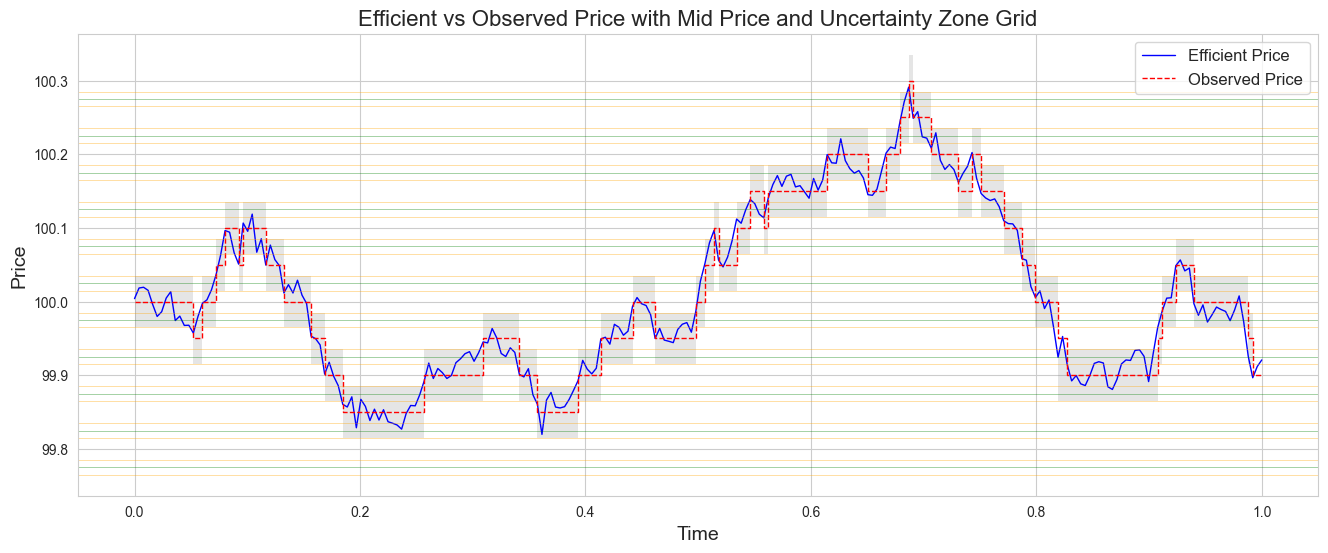

In [24]:
alpha = 0.05      # Tick size
eta = 0.2       # Uncertainty zone width
T = 1.0          # Time horizon
sigma = 0.05/np.sqrt(252)   # Volatility, sigma=0.01  5/np.sqrt(252)
X0 = 100.0       # Initial price
n_steps = 250   # Number of time steps
K = 100 # Strike
number_of_paths = 1000 # For Monto Carlo
t, X = simulate_GBM(T, n_steps, X0, sigma)
plot_uncertainty_zone_matplotlib(X,alpha,eta)

In [7]:
eta = 0.05  # Uncertainty zone width
sigma = 0.01
n_steps = 500

In [8]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the BS price and delta of a European call option.
    """
    if sigma < 0 or T < 0:
        raise ValueError("sigma and T must be greater than zero")
    d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  
    #print(sigma*np.sqrt(T))
    return call_price, delta

In [9]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = int(round(alpha**(-0.5)))  # 取最近的整数
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau

In [29]:
def calculate_hedging_error(t, X, P, tau, K, sigma,use_efficient_price=True):
    """修正后的对冲误差计算函数"""
    T_total = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    calls = np.zeros(len(tau))
    portfolio[0], positions[0] = black_scholes_call(X[tau[0]], K, T - t[tau[0]],0,sigma)

    calls[0] = portfolio[0]
    
    # 动态对冲过程
    for j in range(1, len(tau)):
        if use_efficient_price:
            price_change = X[tau[j]] - X[tau[j-1]]
        else:
            price_change = P[tau[j]] - P[tau[j-1]]
        
        # 更新组合价值
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        

        remaining_T = T_total - t[tau[j]]
        calls[j], positions[j] = black_scholes_call(X[tau[j]], K, remaining_T,0,sigma)
    
    # 计算最终误差
    #final_payoff = max(X[-1] - K, 0)
    #print(portfolio,positions)
    #plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')

    #return final_payoff - portfolio[-1]
    return calls[-1]-portfolio[-1]

In [30]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

In [31]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41261/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


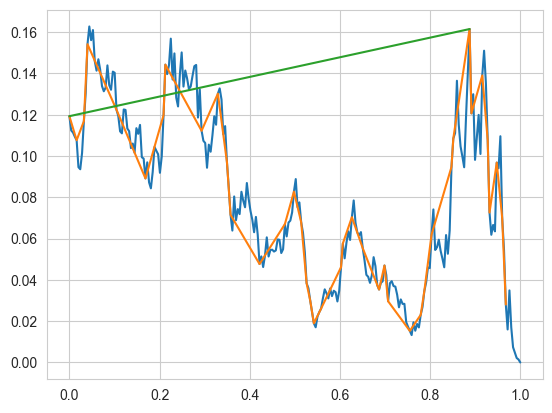

In [32]:
error = np.zeros(1)
for i in range(1):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta,1)
        #P_fixed1, tau_fixed1 = uncertainty_zone_price(X, alpha, eta, 1)

        tau_optimal = get_optimal_tau(X, alpha, eta)
        #print(tau_optimal)
        #print(tau_optimal)
        tau_ideal = list(range(len(t)))  # 所有时间点

        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X,tau_ideal, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma,False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)
        #print(len(tau_fixed))

Processing Paths:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41261/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
Processing Paths: 100%|██████████| 1000/1000 [02:11<00:00,  7.62it/s]


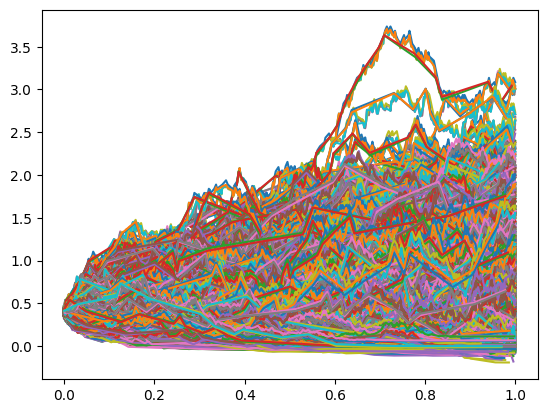

In [14]:
from tqdm import tqdm
for i in tqdm(range(number_of_paths), desc="Processing Paths"):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
        tau_optimal = get_optimal_tau(X, alpha, eta)
        tau_ideal = list(range(len(t)))
        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X, np.arange(len(t)), K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma, False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)

In [15]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

-0.0002604899295782598
-0.11177289359100982
0.014317121065632425
0.015768794577114432
0.048167502602050175
0.044048772084289534


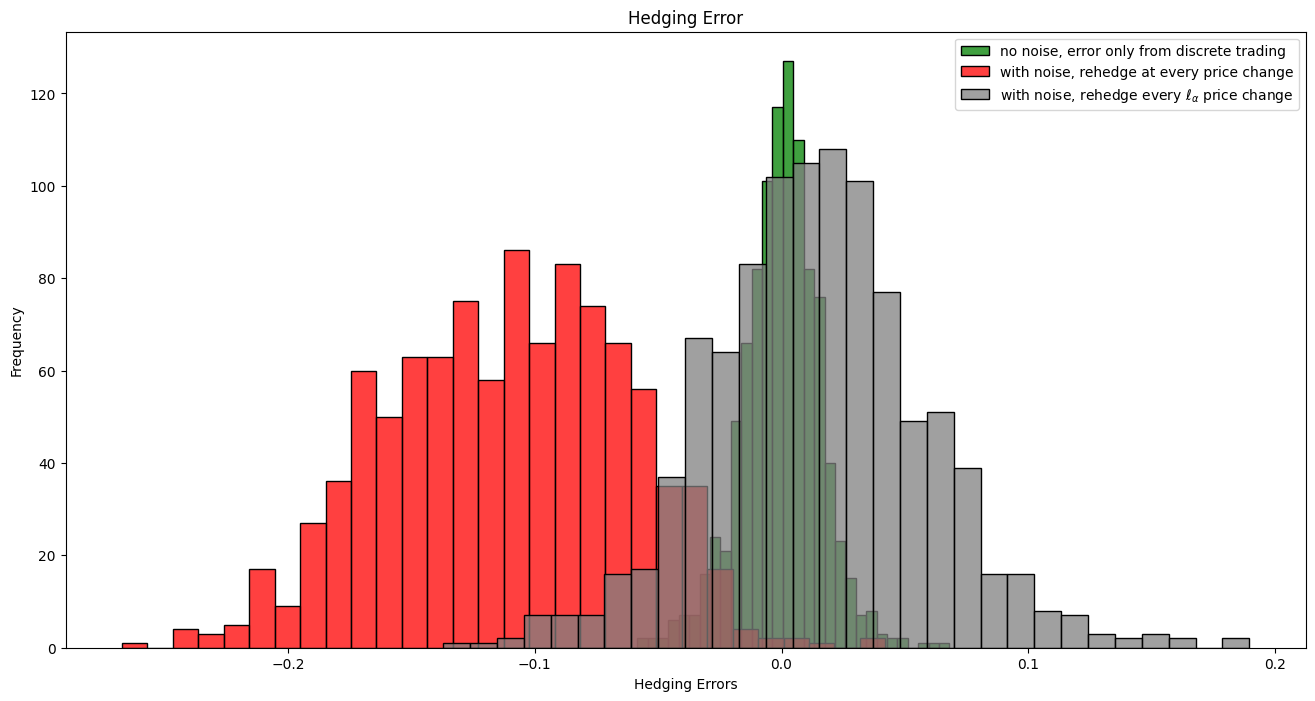

In [16]:
plt.figure(figsize=(16, 8))
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 30, color = 'green',stat = 'count',legend=True)
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 30, color = 'red',stat = 'count',legend=True)
sns.histplot(error_3, label = r"with noise, rehedge every $\ell_\alpha$ price change", bins = 30, color='grey',stat = 'count',legend=True)

plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title("Hedging Error")
plt.legend()
plt.savefig("hedgingError.pdf", format = "pdf")

In [17]:
def simulate_CEV(T, n_steps, X0, sigma, gamma):
    """
    Simulates price paths under the CEV model.
    dX = sigma * X^gamma dW
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    X = np.zeros(n_steps)
    X[0] = X0
    
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    for i in range(1, n_steps):
        X[i] = X[i-1] + sigma * (X[i-1] ** gamma) * dW[i]
    
    return t, X

def simulate_DD(T, n_steps, X0, sigma, beta):
    """
    Simulates price paths under the Displaced Diffusion (DD) model.
    dX = (beta + X) * sigma dW
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    X = np.zeros(n_steps)
    X[0] = X0
    
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    for i in range(1, n_steps):
        X[i] = X[i-1] + (beta + X[i-1]) * sigma * dW[i]
    
    return t, X

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41261/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


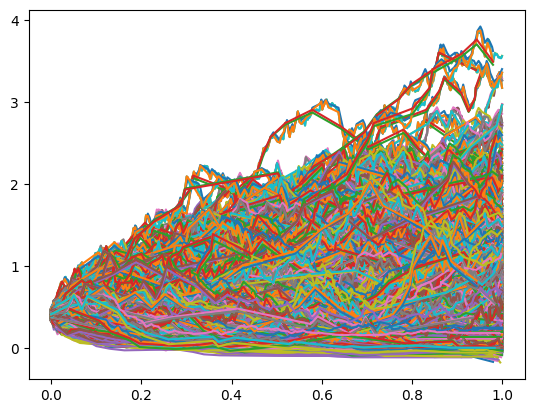

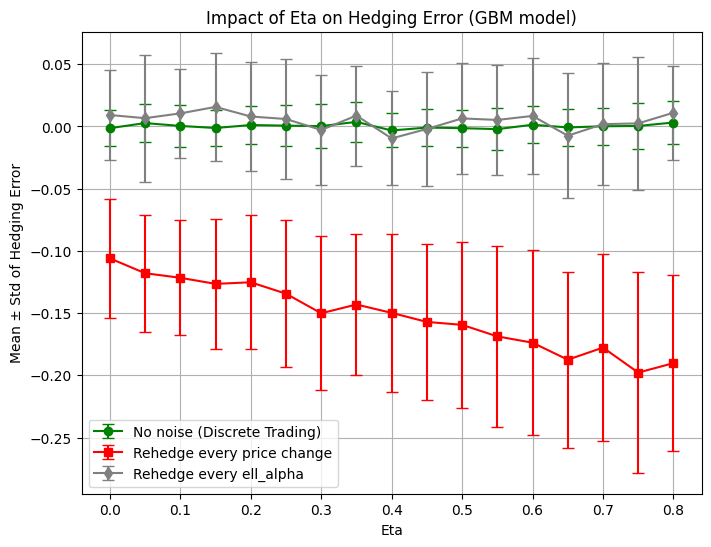

In [20]:
def analyze_eta_impact(eta_values, model='GBM'):
    """
    Plots mean hedging error ± std vs. eta for different hedging strategies.
    """
    mean_errors = {"strategy_1": [], "strategy_2": [], "strategy_3": []}
    std_errors = {"strategy_1": [], "strategy_2": [], "strategy_3": []}
    
    for eta in eta_values:
        errors_1, errors_2, errors_3 = [], [], []
        
        for _ in range(100):  # Monte Carlo simulations
            if model == 'GBM':
                t, X = simulate_GBM(T, n_steps, X0, sigma)
            elif model == 'CEV':
                t, X = simulate_CEV(T, n_steps, X0, sigma, gamma=1.5)
            elif model == 'DD':
                t, X = simulate_DD(T, n_steps, X0, sigma, beta=10)
            else:
                raise ValueError("Unsupported model")
            
            _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
            tau_optimal = get_optimal_tau(X, alpha, eta)
            P_optimal = generate_observed_prices(X, tau_optimal, alpha)
            
            errors_1.append(calculate_hedging_error(t, X, X, np.arange(len(t)), K, sigma))
            errors_2.append(calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma, False))
            errors_3.append(calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False))
        
        mean_errors["strategy_1"].append(np.mean(errors_1))
        mean_errors["strategy_2"].append(np.mean(errors_2))
        mean_errors["strategy_3"].append(np.mean(errors_3))
        
        std_errors["strategy_1"].append(np.std(errors_1))
        std_errors["strategy_2"].append(np.std(errors_2))
        std_errors["strategy_3"].append(np.std(errors_3))
    
    # Plot
    plt.figure(figsize=(8, 6))
    
    plt.errorbar(eta_values, mean_errors["strategy_1"], yerr=std_errors["strategy_1"], 
                 label="No noise (Discrete Trading)", color="green", fmt='-o', capsize=4)
    plt.errorbar(eta_values, mean_errors["strategy_2"], yerr=std_errors["strategy_2"], 
                 label="Rehedge every price change", color="red", fmt='-s', capsize=4)
    plt.errorbar(eta_values, mean_errors["strategy_3"], yerr=std_errors["strategy_3"], 
                 label="Rehedge every ell_alpha", color="grey", fmt='-d', capsize=4)
    
    plt.xlabel("Eta")
    plt.ylabel("Mean ± Std of Hedging Error")
    plt.title(f"Impact of Eta on Hedging Error ({model} model)")
    plt.legend()
    plt.grid()
    plt.show()

# Run analysis
eta_values = np.arange(0, 0.85, 0.05)
analyze_eta_impact(eta_values, model='GBM')  # Change to 'CEV' or 'DD'


/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41261/1116294124.py:7: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41261/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


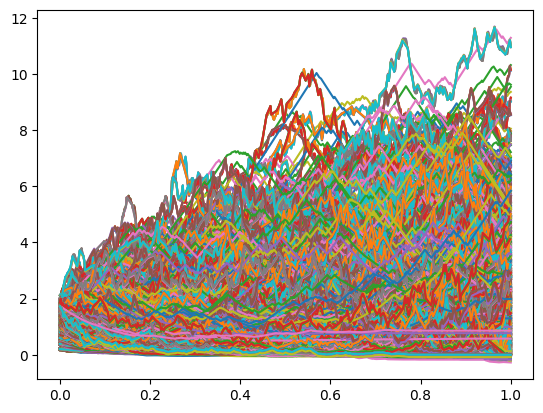

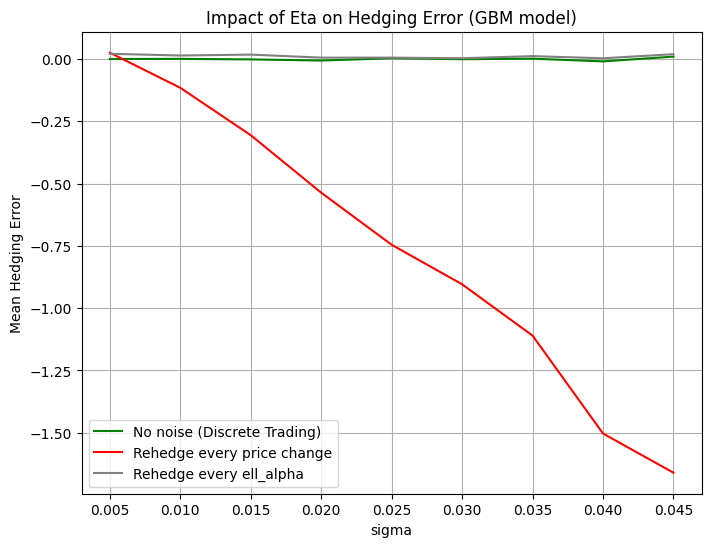

In [19]:
def analyze_sigma_impact(sigma_values, model='GBM'):
    """
    Plots mean hedging error vs. sigma for different hedging strategies.
    """
    mean_errors = {"strategy_1": [], "strategy_2": [], "strategy_3": []}
    
    for sigma in sigma_values:
        errors_1, errors_2, errors_3 = [], [], []
        
        for _ in range(100):  # Monte Carlo simulations
            if model == 'GBM':
                t, X = simulate_GBM(T, n_steps, X0, sigma)
            elif model == 'CEV':
                t, X = simulate_CEV(T, n_steps, X0, sigma, gamma=1.5)
            elif model == 'DD':
                t, X = simulate_DD(T, n_steps, X0, sigma, beta=10)
            else:
                raise ValueError("Unsupported model")
            
            _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
            tau_optimal = get_optimal_tau(X, alpha, eta)
            P_optimal = generate_observed_prices(X, tau_optimal, alpha)
            
            errors_1.append(calculate_hedging_error(t, X, X, np.arange(len(t)), K, sigma))
            errors_2.append(calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma, False))
            errors_3.append(calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False))
            
        mean_errors["strategy_1"].append(np.mean(errors_1))
        mean_errors["strategy_2"].append(np.mean(errors_2))
        mean_errors["strategy_3"].append(np.mean(errors_3))
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(sigma_values, mean_errors["strategy_1"], label="No noise (Discrete Trading)", color="green")
    plt.plot(sigma_values, mean_errors["strategy_2"], label="Rehedge every price change", color="red")
    plt.plot(sigma_values, mean_errors["strategy_3"], label="Rehedge every ell_alpha", color="grey")
    
    plt.xlabel("sigma")
    plt.ylabel("Mean Hedging Error")
    plt.title(f"Impact of Eta on Hedging Error ({model} model)")
    plt.legend()
    plt.grid()
    plt.show()

# Run analysis
sigma_values = np.arange(0, 0.05, 0.005)
analyze_sigma_impact(sigma_values, model='GBM')  # Change to 'CEV' or 'DD'